**Общая информация**

**Срок сдачи:** 21 октября 2019, 08:30 

**Штраф за опоздание:** по 0.5 балла за 24 часа задержки. Через 10 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0919, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Невыполнение PEP8 -0.5 баллов
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import re
import numpy as np
from tabulate import tabulate
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from IPython.display import HTML, display

from sklearn import datasets
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata, fetch_20newsgroups

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 

from sklearn.neighbors import KDTree
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfTransformer

from scipy.stats import mode
from scipy.sparse import csr_matrix

%load_ext pycodestyle_magic

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе. Score не должен уступать значению KNN из sklearn

In [2]:
class MyKNeighborsClassifier(
        NeighborsBase, KNeighborsMixin,
        SupervisedIntegerMixin, ClassifierMixin):

    def __init__(self, n_neighbors, algorithm='brute', metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm

        if metric in ['euclidean', 'cosine']:
            self.metric = metric
        else:
            raise ValueError("Only \'euclidean\' and "
                             "\'cosine\' metrics are supported")

    def fit(self, X, y):
        self.X = X
        self.y = y

        if self.algorithm == 'kd_tree':
            self.kd_tree = KDTree(self.X, leaf_size=30, metric=self.metric)

    def predict(self, X):
        if self.algorithm == 'brute':
            distances = pairwise_distances(X, self.X, metric=self.metric)
            neigbor_idxs = np.argpartition(distances, self.n_neighbors, axis=1)
            neigbor_idxs = neigbor_idxs[..., :self.n_neighbors]
            predictions = mode(self.y[neigbor_idxs], axis=1)[0]

            return predictions.ravel()

        elif self.algorithm == 'kd_tree':
            neigbor_idxs = self.kd_tree.query(X, k=self.n_neighbors)[1]
            predictions = mode(self.y[neigbor_idxs], axis=1)[0]

            return predictions.ravel()

    def predict_proba(self, X):
        classes = np.unique(self.y)

        if self.algorithm == 'brute':
            distances = pairwise_distances(X, self.X, metric=self.metric)
            neigbor_idxs = np.argpartition(distances, self.n_neighbors, axis=1)
            neigbor_idxs = neigbor_idxs[..., :self.n_neighbors]

            probs = np.zeros((y_train[neigbor_idxs].shape[0], classes.shape[0]))
            for idx, row in enumerate(y_train[neigbor_idxs]):
                probs[idx] = np.bincount(row, minlength=classes.shape[0])

            return probs / probs.sum(axis=1, keepdims=True)

        elif self.algorithm == 'kd_tree':
            neigbor_idxs = self.kd_tree.query(X, k=self.n_neighbors)[1]

            probs = np.zeros((y_train[neigbor_idxs].shape[0], classes.shape[0]))
            for idx, row in enumerate(y_train[neigbor_idxs]):
                probs[idx] = np.bincount(row, minlength=classes.shape[0])

            return probs / probs.sum(axis=1, keepdims=True)

    def score(self, X, y):
        return np.array(self.predict(X) == y).mean()

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [7]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy

In [8]:
%time clf.fit(X_train, y_train)

CPU times: user 829 µs, sys: 35 µs, total: 864 µs
Wall time: 632 µs


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [9]:
%time my_clf.fit(X_train, y_train)

CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 15.7 µs


In [10]:
%time clf.predict(X_test)

CPU times: user 9.56 ms, sys: 0 ns, total: 9.56 ms
Wall time: 1.54 ms


array([0, 0, 1, 1, 0, 2, 2, 2, 1, 0, 1, 2, 0, 1, 2])

In [11]:
%time my_clf.predict(X_test)

CPU times: user 13 ms, sys: 0 ns, total: 13 ms
Wall time: 1.73 ms


array([0, 0, 1, 1, 0, 2, 2, 2, 1, 0, 1, 2, 0, 1, 2])

In [12]:
%time clf.predict_proba(X_test)

CPU times: user 5.99 ms, sys: 68 µs, total: 6.06 ms
Wall time: 1.21 ms


array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [13]:
%time my_clf.predict_proba(X_test)

CPU times: user 5.02 ms, sys: 176 µs, total: 5.2 ms
Wall time: 837 µs


array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy. Score не должен уступать значению KNN из sklearn

In [14]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [15]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [16]:
%time clf.fit(X_train, y_train)

CPU times: user 1.29 ms, sys: 42 µs, total: 1.33 ms
Wall time: 1.13 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [17]:
%time my_clf.fit(X_train, y_train)

CPU times: user 220 µs, sys: 0 ns, total: 220 µs
Wall time: 213 µs


In [18]:
%time clf.predict(X_test)

CPU times: user 3.26 ms, sys: 0 ns, total: 3.26 ms
Wall time: 2.25 ms


array([0, 2, 0, 0, 0, 1, 1, 1, 1, 2, 1, 0, 2, 2, 2])

In [19]:
%time my_clf.predict(X_test)

CPU times: user 1.76 ms, sys: 57 µs, total: 1.81 ms
Wall time: 1.34 ms


array([0, 2, 0, 0, 0, 1, 1, 1, 1, 2, 1, 0, 2, 2, 2])

In [20]:
%time clf.predict_proba(X_test)

CPU times: user 379 µs, sys: 907 µs, total: 1.29 ms
Wall time: 916 µs


array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [21]:
%time my_clf.predict_proba(X_test)

CPU times: user 0 ns, sys: 928 µs, total: 928 µs
Wall time: 591 µs


array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [22]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [23]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [24]:
data = newsgroups['data']
target = newsgroups['target']

Переведите во всех документах все буквы в нижний регистр и замените во всех документах символы, не
являющиеся буквами и цифрами, на пробелы. Далее разбейте текста по пробельным символам на токены(термы/слова). Удалите текста, содержащие только пробелы.

In [25]:
def process_data(data, target):
    data_tok = []
    target_tok = []
    for text, trg in zip(data, target):
        text = re.sub('[^a-z0-9]', ' ', text.lower())

        if text and not text.isspace():
            data_tok.append(list(filter(None, text.split())))
            target_tok.append(trg)

    return data_tok, np.array(target_tok)


data_tok, target_tok = process_data(data, target)

In [26]:
assert all(isinstance(row, (list, tuple)) for row in data_tok), "please convert each line into a list of tokens (strings)"
assert all(all(isinstance(tok, str) for tok in row) for row in data_tok), "please convert each line into a list of tokens (strings)"
is_latin = lambda tok: all('a' <= x.lower() <= 'z' for x in tok)
assert all(map(lambda l: not is_latin(l) or l.islower() , map(' '.join, data_tok))), "please make sure that you lowercase the data and drop spaced texts"

Преобразуйте датасет в разреженную матрицу scipy.sparse.csr_matrix, где значение x в позиции (i, j)
означает, что в документе i слово j встретилось x раз

In [27]:
def make_sparse(data, vocabulary, create_new=True):
    indptr = [0]
    indices = []
    dt = []
    for d in data:
        for term in d:
            if create_new:
                index = vocabulary.setdefault(term, len(vocabulary))
            elif term in vocabulary:
                index = vocabulary[term]
            else:
                continue
            indices.append(index)
            dt.append(1)
        indptr.append(len(indices))
    return csr_matrix((dt, indices, indptr)), vocabulary


csr, vocabulary = make_sparse(data_tok, {})

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [28]:
my_clf = MyKNeighborsClassifier(n_neighbors=2)
skf = StratifiedKFold(n_splits=3)

In [29]:
for train_idx, test_idx in skf.split(csr, target_tok):
    my_clf.fit(csr[train_idx], target_tok[train_idx])
    print(my_clf.score(csr[test_idx], target_tok[test_idx]))

0.18738101713353278
0.19247546346782987
0.1948619841486745


Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальный score в среднем на валидации на 3 фолдах).
Постройте график зависимости среднего score от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [30]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
Ks = []
Scores = []
for K in tqdm_notebook(range(1, 10 + 1)):
    clf = MyKNeighborsClassifier(n_neighbors=K)
    score = []

    for train_idx, test_idx in skf.split(csr, target_tok):
        clf.fit(csr[train_idx], target_tok[train_idx])
        score.append(clf.score(csr[test_idx], target_tok[test_idx]))

    Ks.append(K)
    Scores.append(np.mean(score))

Text(0.5, 0, 'Number of neighbors - K')

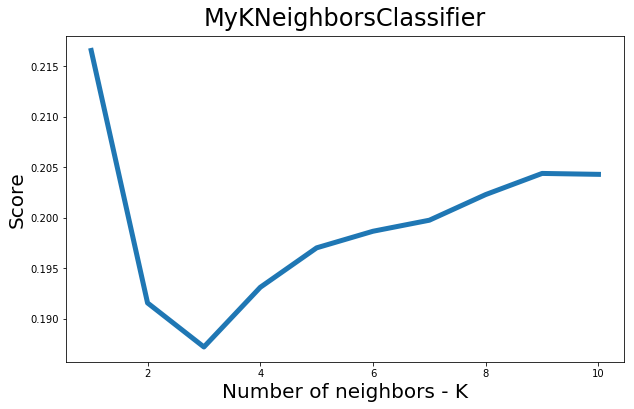

In [31]:
plt.figure(figsize=(10, 6))
plt.title("MyKNeighborsClassifier", fontsize=24, pad=10)
plt.plot(Ks, Scores, linewidth=5.0)
plt.ylabel("Score", fontsize=20)
plt.xlabel("Number of neighbors - K", fontsize=20)

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf преобразование( sklearn.feature_extraction.text.TfidfTransformer)

Сравните модели, выберите лучшую.

In [32]:
trans_csr = TfidfTransformer().fit_transform(csr, target_tok)

In [33]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
Ks_tr = []
Scores_tr = []
for K in tqdm_notebook(range(1, 10 + 1)):
    clf = MyKNeighborsClassifier(n_neighbors=K, metric='cosine')
    score = []

    for train_idx, test_idx in skf.split(trans_csr, target_tok):
        clf.fit(trans_csr[train_idx], target_tok[train_idx])
        score.append(clf.score(trans_csr[test_idx], target_tok[test_idx]))

    Ks_tr.append(K)
    Scores_tr.append(np.mean(score))

Text(0.5, 0, 'Number of neighbors - K')

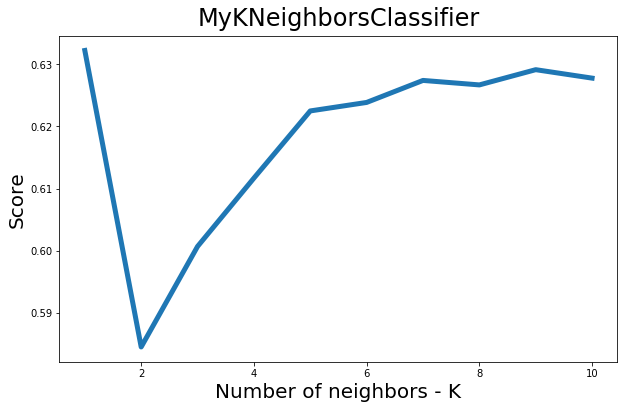

In [34]:
plt.figure(figsize=(10, 6))
plt.title("MyKNeighborsClassifier", fontsize=24, pad=10)
plt.plot(Ks_tr, Scores_tr, linewidth=5.0)
plt.ylabel("Score", fontsize=20)
plt.xlabel("Number of neighbors - K", fontsize=20)

Text(0.5, 0, 'Number of neighbors - K')

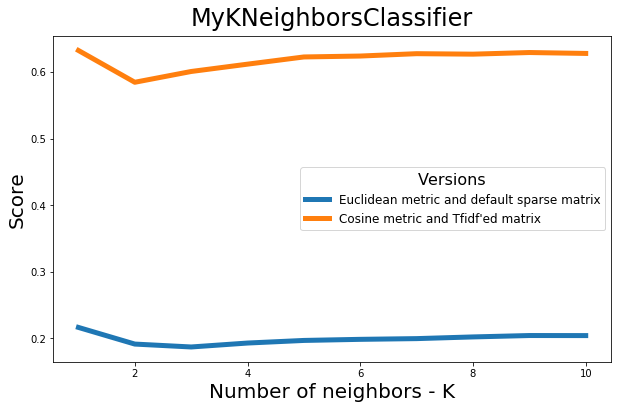

In [35]:
plt.figure(figsize=(10, 6))
plt.title("MyKNeighborsClassifier", fontsize=24, pad=10)
plt.plot(Ks, Scores, linewidth=5.0, label="Euclidean metric and default sparse matrix")
plt.plot(Ks_tr, Scores_tr, linewidth=5.0, label="Cosine metric and Tfidf'ed matrix")
plt.legend(title="Versions", title_fontsize=16, loc="right", fontsize=12)
plt.ylabel("Score", fontsize=20)
plt.xlabel("Number of neighbors - K", fontsize=20)

In [36]:
table = {"K" : Ks, "Euclidean" : Scores, "Cosine" : Scores_tr}
display(HTML(tabulate(table, headers='keys', tablefmt='html')))

K,Euclidean,Cosine
1,0.216558,0.632229
2,0.191573,0.584495
3,0.187215,0.600677
4,0.193121,0.61168
5,0.197026,0.622494
6,0.198668,0.623862
7,0.19976,0.627405
8,0.2023,0.626684
9,0.204389,0.629135
10,0.204299,0.627776


__Единица нам, очевидно, не подходит, значит 9 — оптимальный параметр.__

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [37]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

In [38]:
data_test, target_test = process_data(newsgroups['data'], newsgroups['target'])

In [39]:
csr_test, _ = make_sparse(data_test, vocabulary, False)
trans_csr_test = TfidfTransformer().fit_transform(csr_test, target_test)

Оценим качество(score) вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [40]:
my_clf = MyKNeighborsClassifier(n_neighbors=9, metric='cosine')
my_clf.fit(trans_csr, target_tok)
my_clf.score(trans_csr_test, target_test)

0.5732658366397592

Качество упало из-за неполного соответствия наборов слов в обучающей и тестовой выборке.